# Hierarchical Bayesian Neural Networks

"Flaxified" version of the [`bnn_hierarchical.ipynb`](https://github.com/probml/pyprobml/blob/master/notebooks/book2/17/bnn_hierarchical.ipynb) notebook. The implementation of this HBNN is model-indpendent, as long as the model is specified using flax.

In [1]:
import hbnn
import jax
import blackjax
import einops
import jax.numpy as jnp
import matplotlib.pyplot as plt
import flax.linen as nn
from functools import partial
from sklearn.datasets import make_moons
from sklearn.metrics import confusion_matrix

In [2]:
%config InlineBackend.figure_format = "retina"
cmap = plt.cm.tab10(jnp.linspace(0, 1, 10))

In [3]:
def rotation_matrix(angle):
    """
    Create a rotation matrix that rotates the
    space 'angle'-radians.
    """
    R = jnp.array([[jnp.cos(angle), -jnp.sin(angle)], [jnp.sin(angle), jnp.cos(angle)]])
    return R


def make_rotating_moons(radians, n_samples=100, **kwargs):
    """
    Make two interleaving half circles rotated by 'radians' radians

    Parameters
    ----------
    radians: float
        Angle of rotation
    n_samples: int
        Number of samples
    **kwargs:
        Extra arguments passed to the `make_moons` function
    """
    X, y = make_moons(n_samples=n_samples, **kwargs)
    X = jnp.einsum("nm,mk->nk", X, rotation_matrix(radians))
    return X, y

## Hierarchical model

We consider a hierarchical model which has a common Gaussian prior for all the weights, but allows each task to have its own task-specific parameters. More precisely, let $w^{t}_{ijl}\sim\mathcal{N}(\mu_{ijl}, 0)$ be the weight for node $i$ to node $j$ in layer $l$ at task $t$. We assume

$$
\begin{aligned}
    \sigma_l &\sim \mathcal{N}^+(0,1)\\
    \mu_{ijl} &\sim \mathcal{N}(0, 1)\\
    \varepsilon^t_{ijl} &\sim \mathcal{N}(0, 1)\\
    w^t_{ijl} &\sim \mathcal{N}(\mu_{ijl}, \sigma_l)
\end{aligned}
$$

Or, in non-centred form,

$$
    w^t_{ijl} = \mu_{ijl} + \varepsilon^t_{ijl} \sigma_l
$$

In [4]:
key = jax.random.PRNGKey(314)
key_samples, key = jax.random.split(key)

## Create dataset

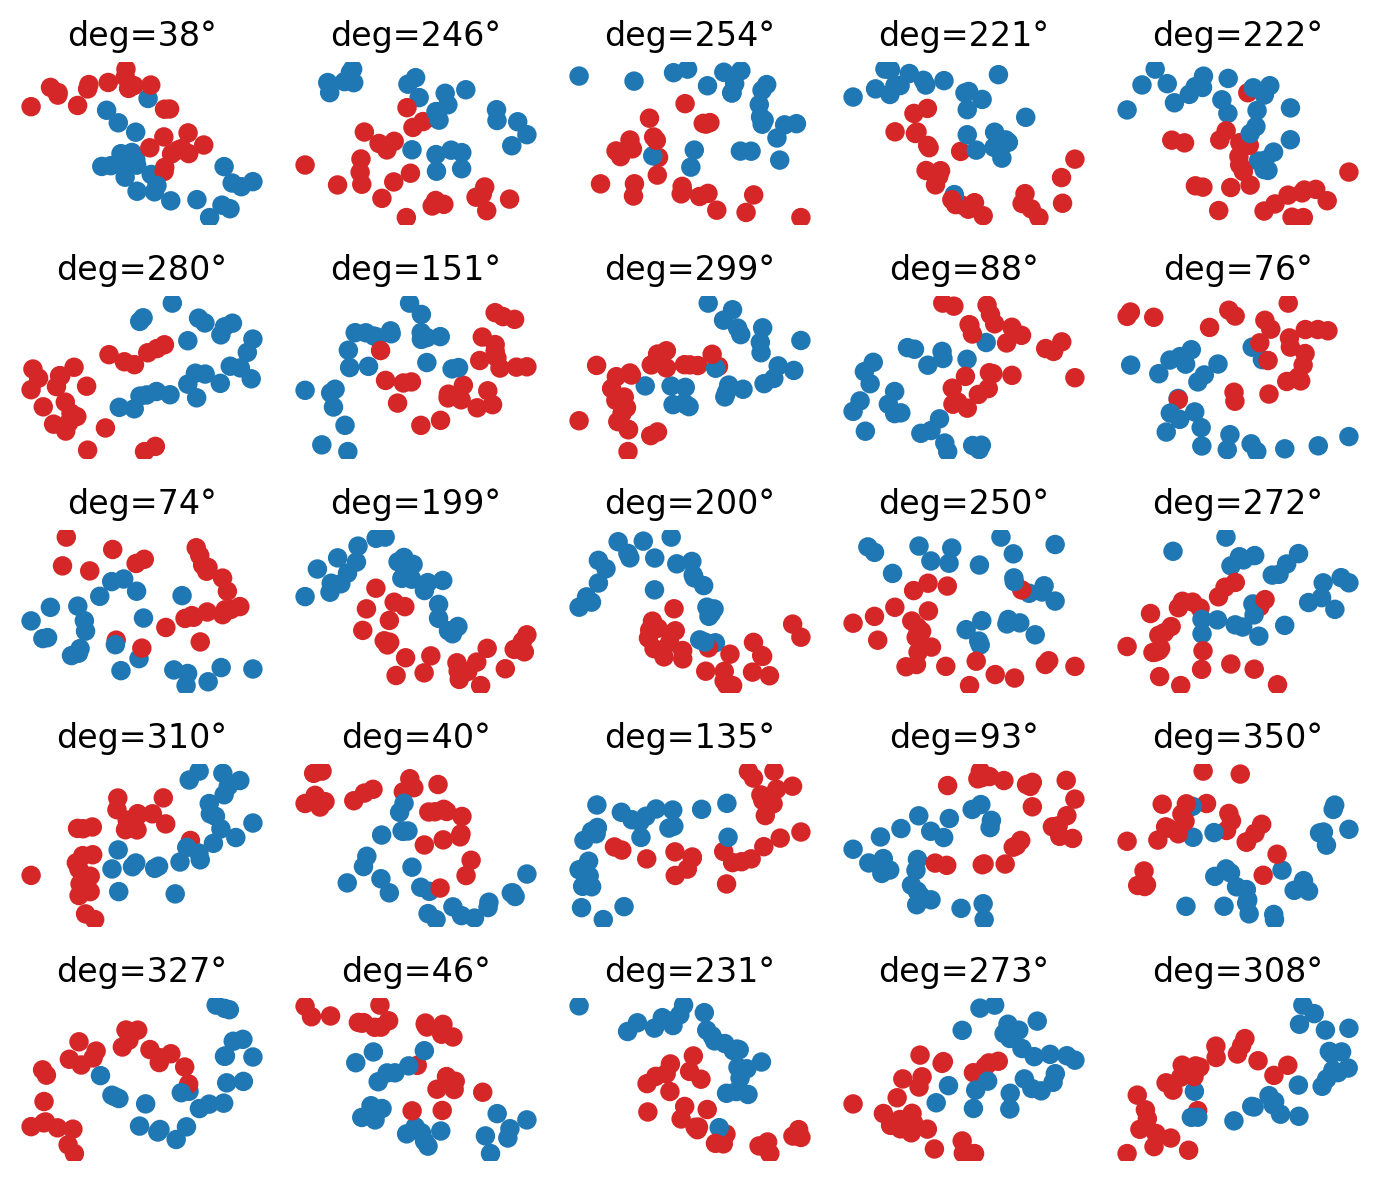

In [5]:
fig, ax = plt.subplots(5, 5, figsize=(7, 6))
ax = ax.ravel()

n_radians = 25
noise = 0.2
n_samples = 50
radians_rand = jax.random.uniform(key_samples, (n_radians,)) * 2 * jnp.pi

X_collection = []
y_collection = []

for axi, rad in zip(ax, radians_rand):
    X, y = make_rotating_moons(rad, n_samples, noise=noise)
    c = ["tab:blue" if yn == 1 else "tab:red" for yn in y]
    axi.scatter(*X.T, c=c)
    axi.axis("off")

    X_collection.append(X)
    y_collection.append(y)

    deg = rad * 180 / jnp.pi
    axi.set_title(f"{deg=:0.0f}°")
plt.tight_layout()

X_collection = jnp.stack(X_collection)
y_collection = jnp.stack(y_collection)
Y_collection = jax.nn.one_hot(y_collection, 2)

## Building model

In [6]:
key_model_init, key_state_init, key_warmup, key_sample = jax.random.split(key, 4)

In [7]:
class MLP(nn.Module):
    """
    Multi-layered perceptron for classificaton.
    """

    # num_outputs: int
    @nn.compact
    def __call__(self, x):
        x = nn.tanh(nn.Dense(6)(x))
        x = nn.tanh(nn.Dense(6)(x))
        x = nn.Dense(2)(x)
        return x


model = MLP()
batch = jnp.ones((n_samples, 2))
params_all, model_treedef = hbnn.init_params(key_model_init, model, batch, n_radians)

In [8]:
%%time
num_warmup = 1500
num_samples = 500

potential = partial(hbnn.hierarchical_log_joint, X=X_collection, y=Y_collection,
                    model=model, model_treedef=model_treedef)

adapt = blackjax.window_adaptation(blackjax.nuts, potential)
(state, parameters), _ = adapt.run(key_warmup, params_all)#, num_warmup)
kernel = blackjax.nuts(potential, **parameters).step


states = hbnn.inference_loop(key_sample, kernel, state, num_samples)
sampled_params = states.position

CPU times: user 24.9 s, sys: 1.12 s, total: 26 s
Wall time: 25.1 s


## Evaluating grid

In [9]:
logits = hbnn.vmap_eval_tasks(sampled_params, X_collection, model, model_treedef)

In [10]:
step = 0.1
vmin, vmax = X_collection.min() - step, X_collection.max() + step
X_grid = jnp.mgrid[vmin:vmax:50j, vmin:vmax:50j]

logits_grid = hbnn.eval_tasks_grid(sampled_params, X_grid, model, model_treedef)

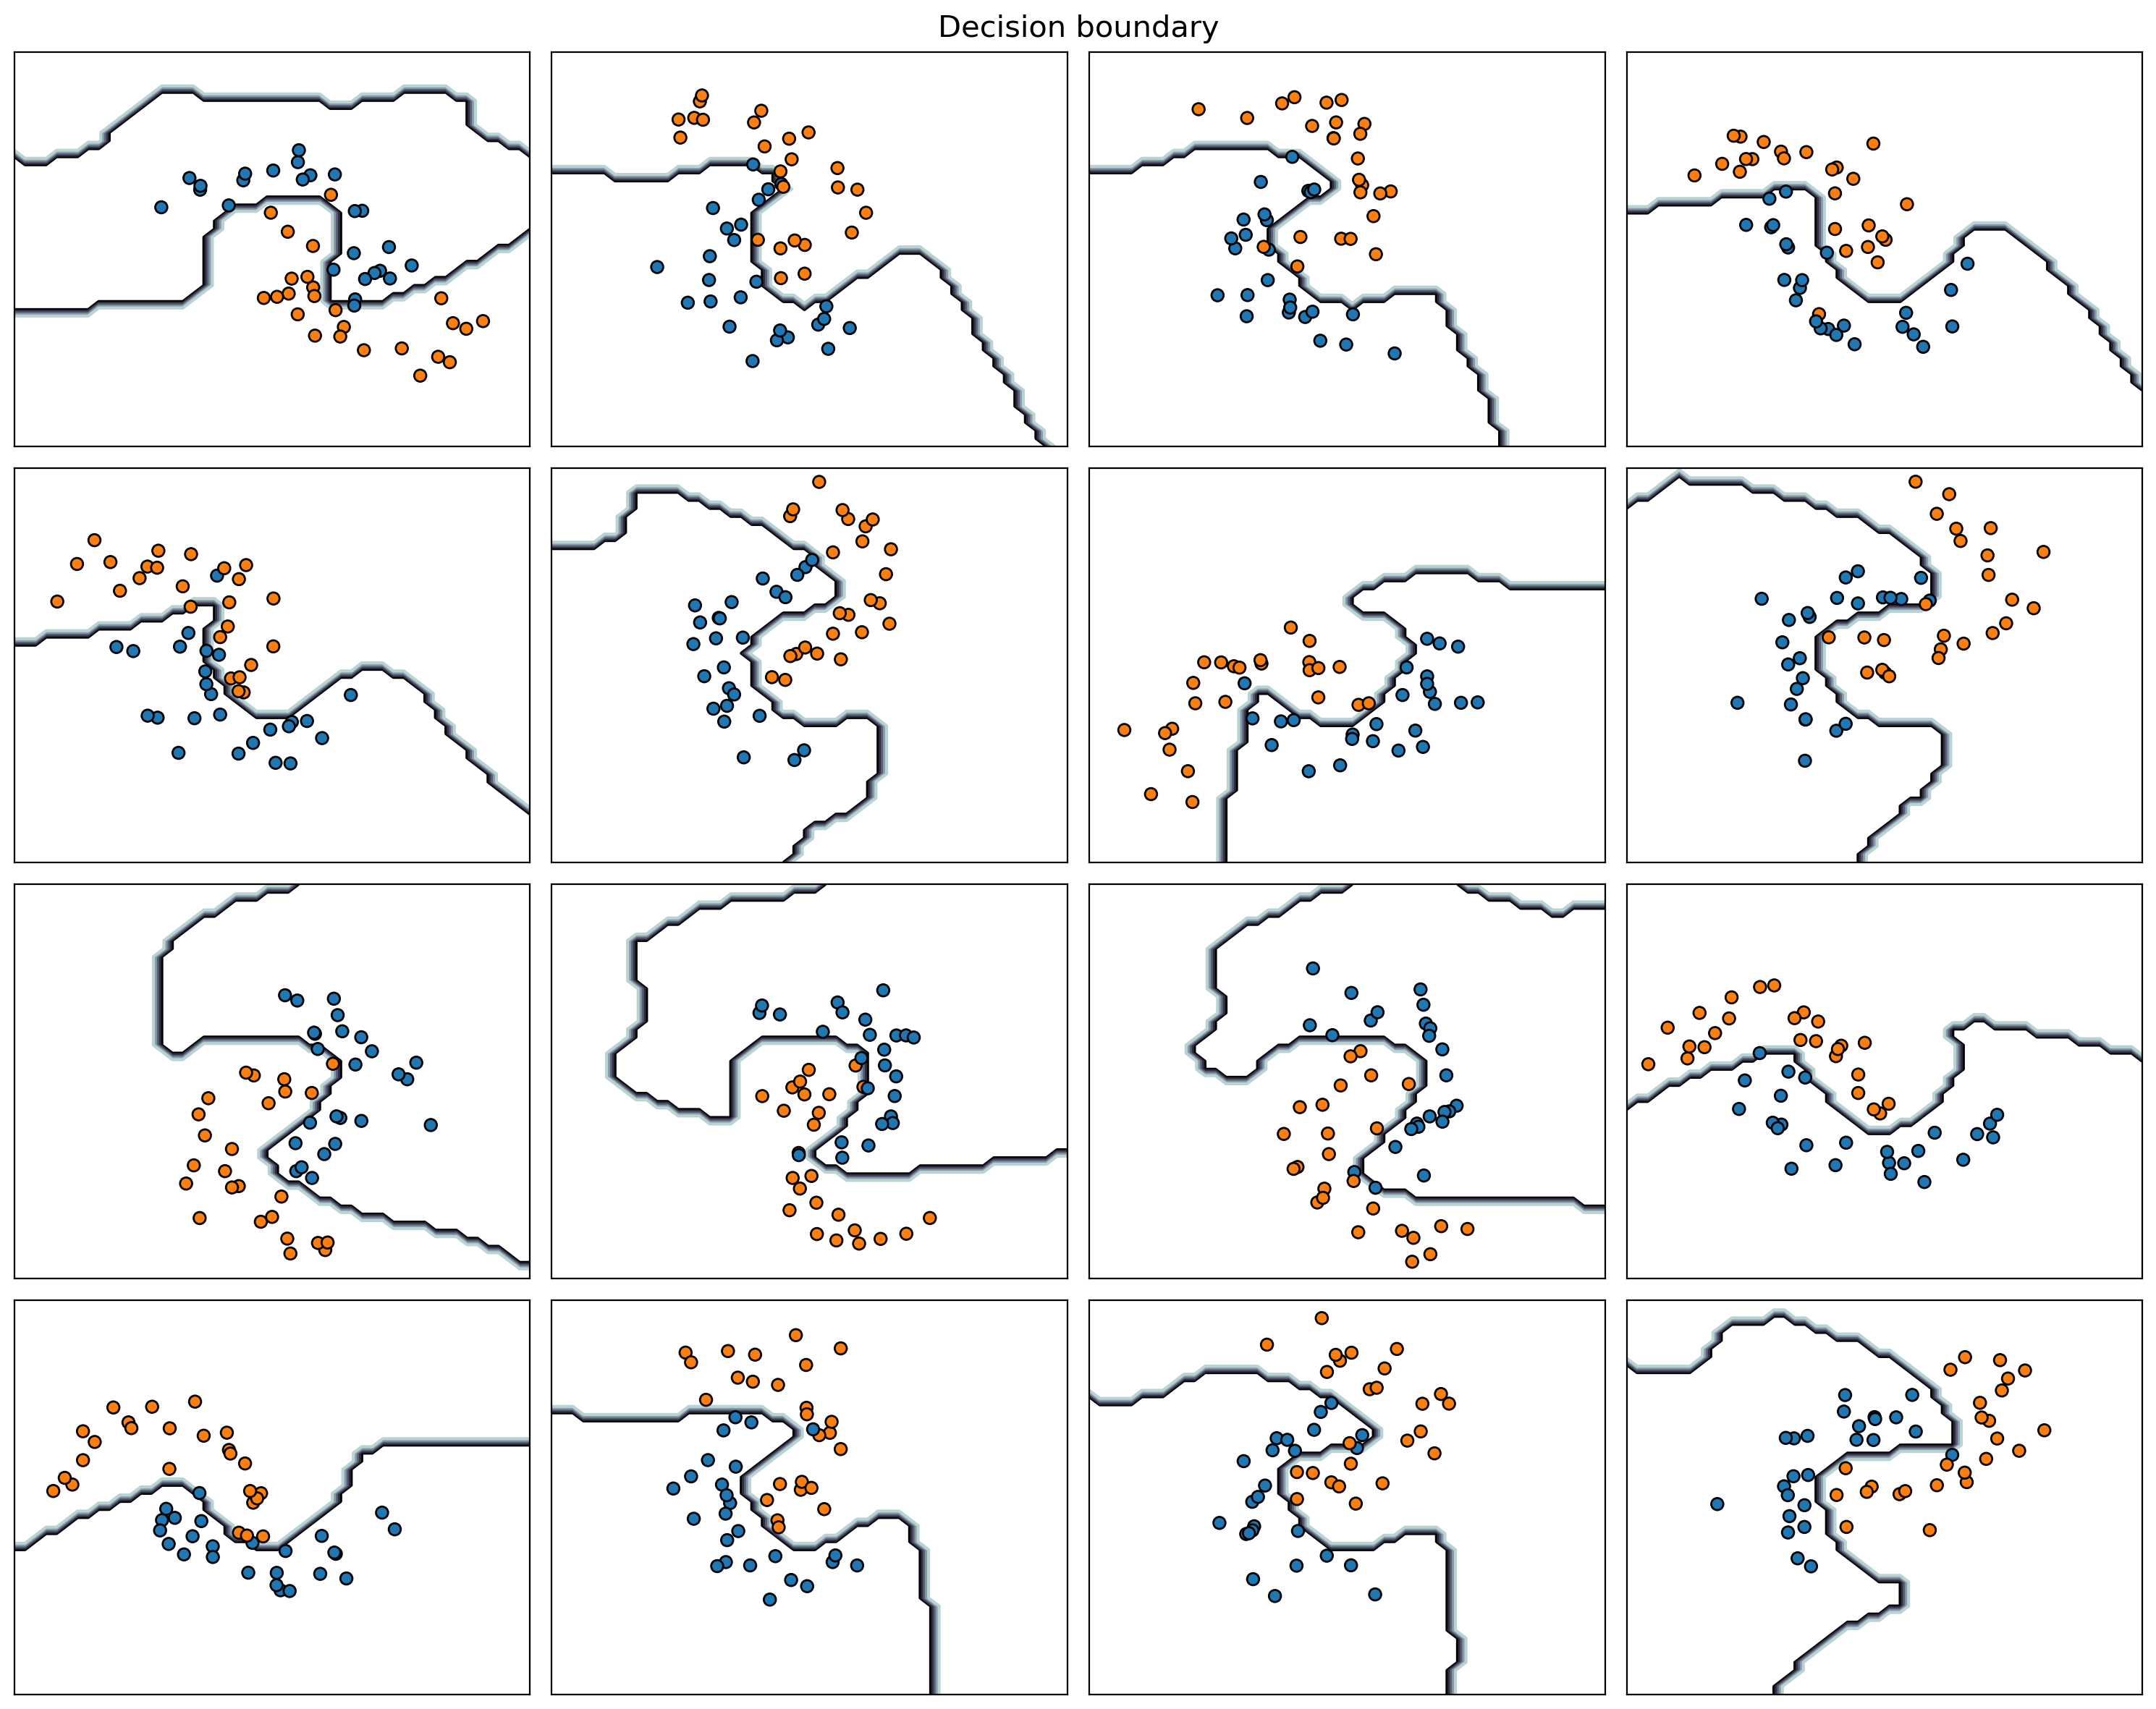

In [11]:
class_grid = nn.softmax(logits_grid)
class_grid = class_grid.mean(axis=0).argmax(axis=-1)
class_grid = einops.rearrange(class_grid, "x y n_configs -> n_configs x y")

fig, ax = plt.subplots(4, 4, figsize=(15, 12))
for axi, pv, X, y in zip(ax.ravel(), class_grid, X_collection, y_collection):
    colors = cmap[y.astype(int)]
    axi.contour(*X_grid, pv, zorder=0, cmap="bone", levels=4)
    axi.scatter(*X.T, c=colors, zorder=1, edgecolor="black")
    axi.set_xlim(vmin, vmax)
    axi.set_ylim(vmin, vmax)
    axi.axes.xaxis.set_visible(False)
    axi.axes.yaxis.set_visible(False)

plt.suptitle("Decision boundary", fontsize=15)
plt.tight_layout()

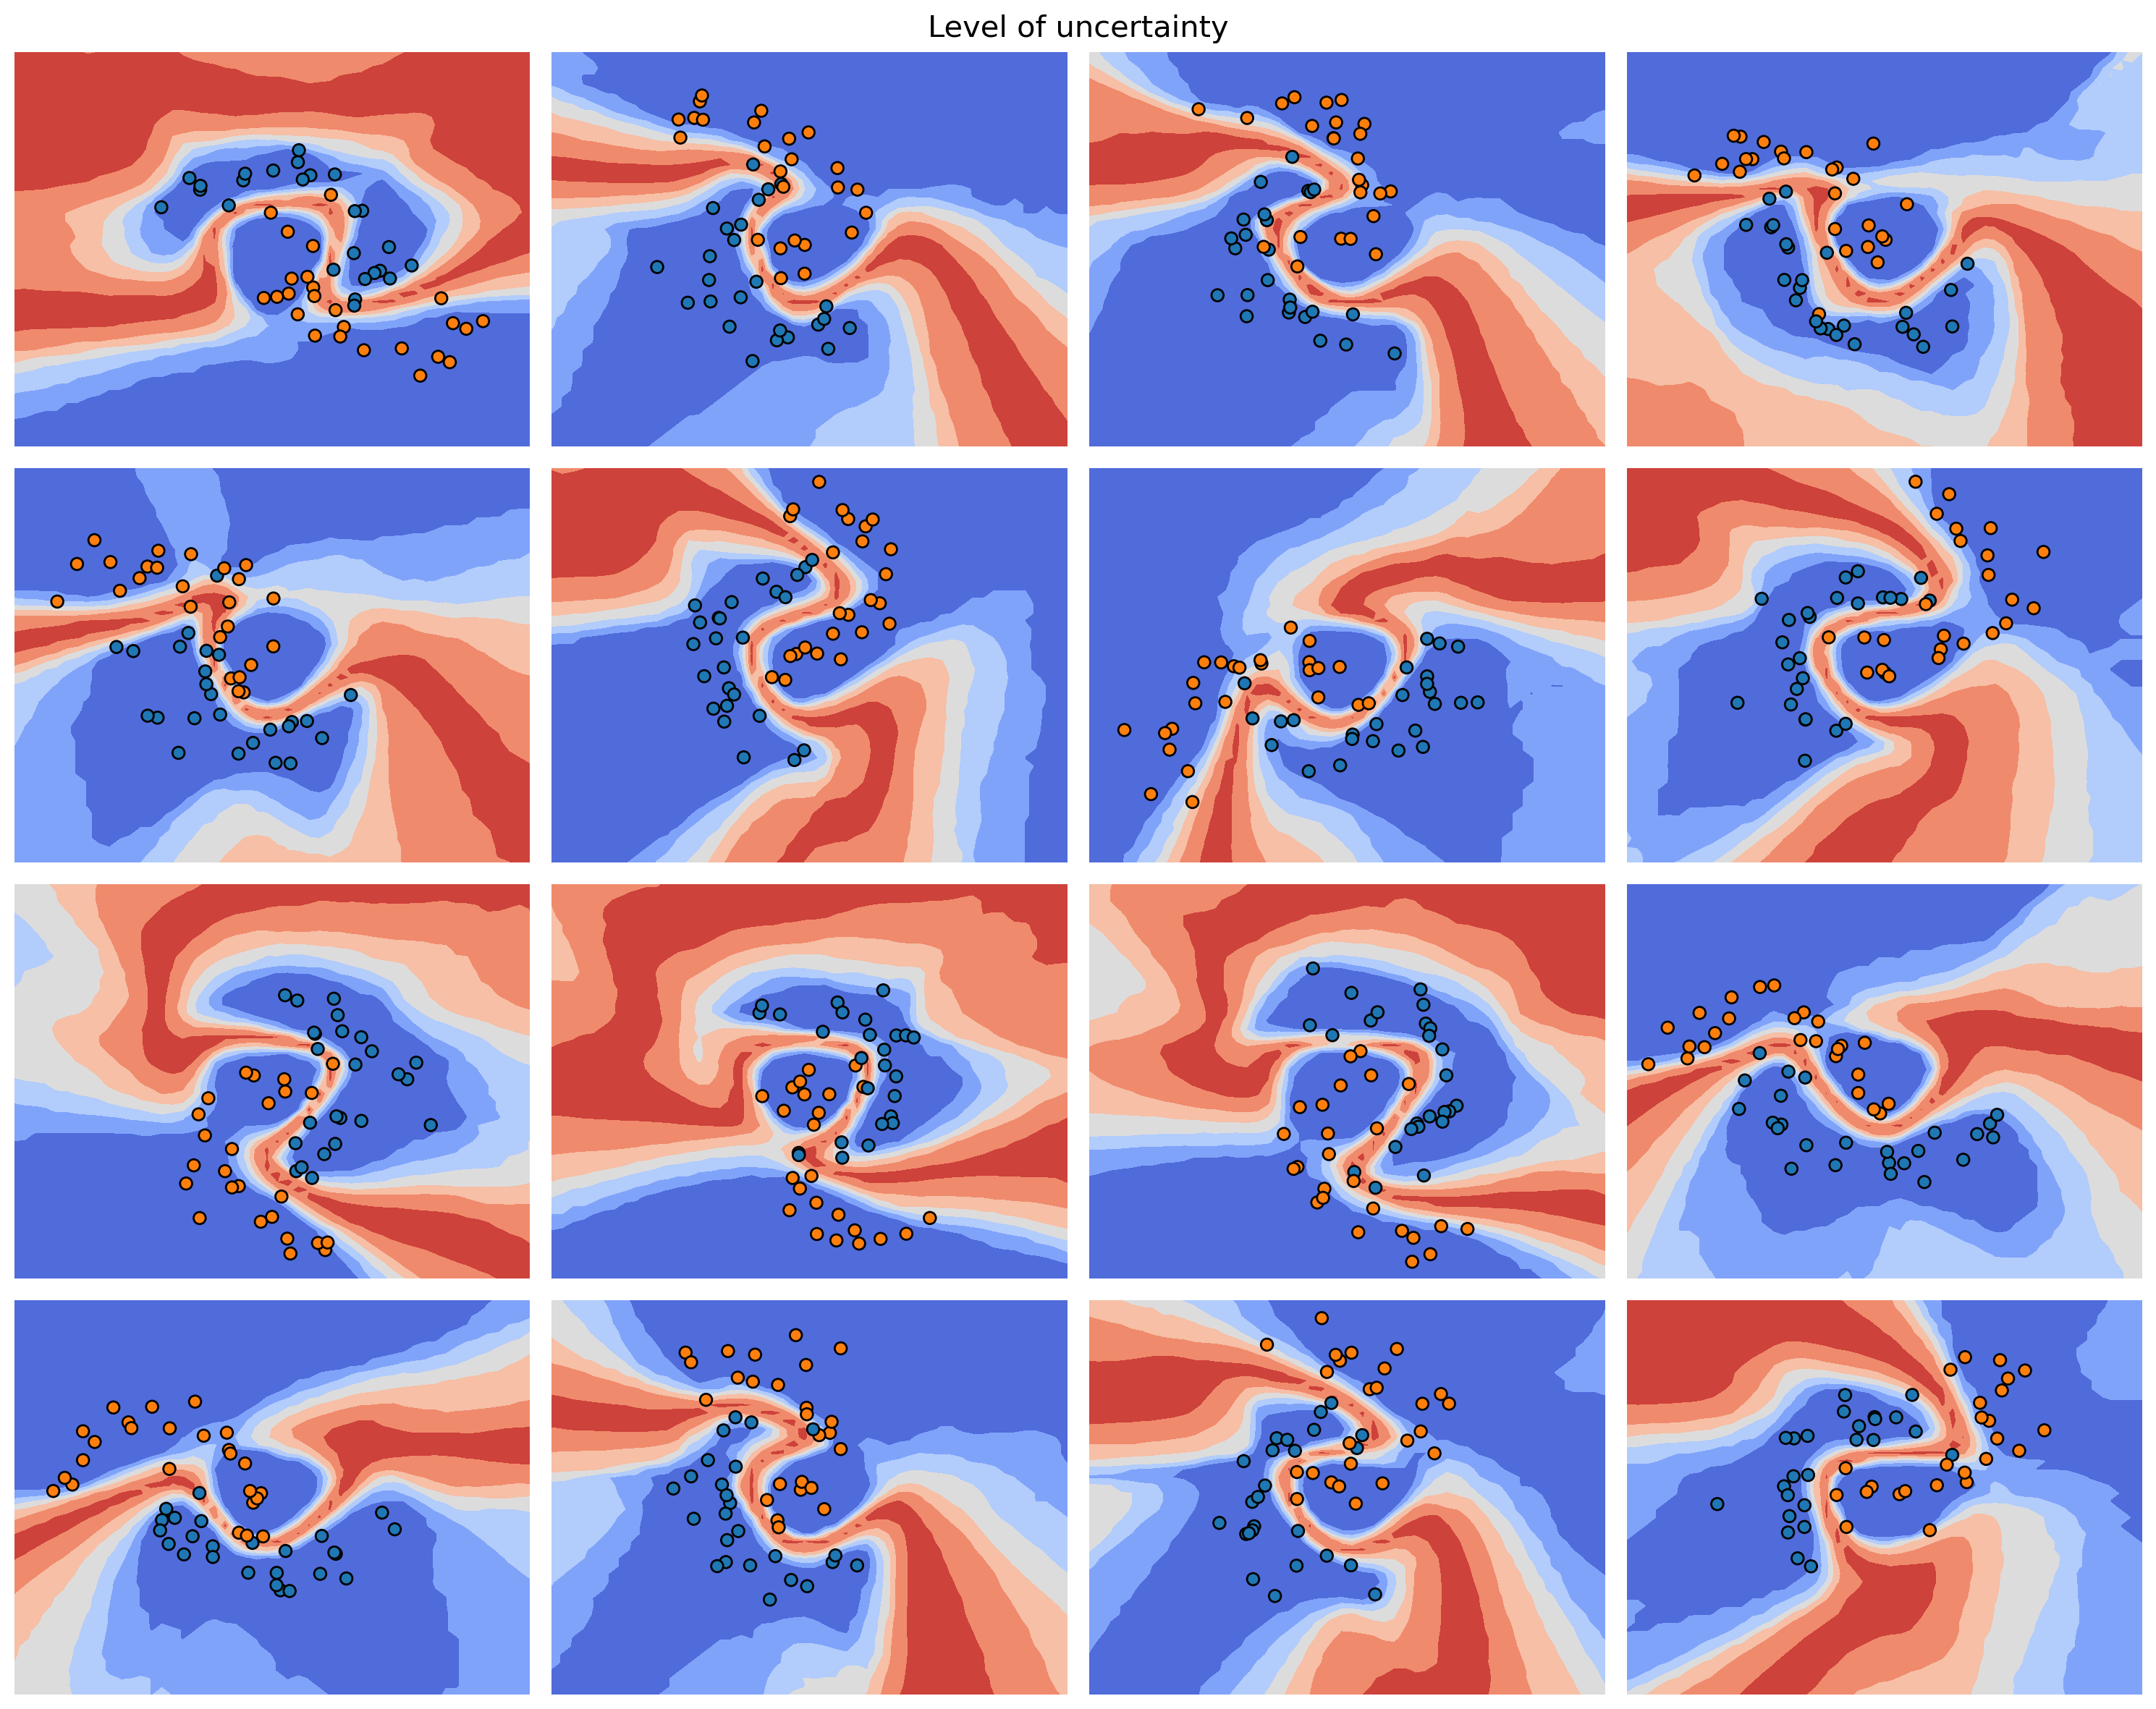

In [12]:
class_grid = nn.softmax(logits_grid)
class_grid = class_grid.argmax(axis=-1).std(axis=0)
class_grid = einops.rearrange(class_grid, "x y n_configs -> n_configs x y")

fig, ax = plt.subplots(4, 4, figsize=(15, 12))
for axi, pv, X, y in zip(ax.ravel(), class_grid, X_collection, y_collection):
    colors = cmap[y.astype(int)]
    axi.contourf(*X_grid, pv, zorder=0, cmap="coolwarm")
    axi.scatter(*X.T, c=colors, zorder=1, edgecolors="black")
    axi.axis("off")
    axi.set_xlim(vmin, vmax)
    axi.set_ylim(vmin, vmax)
plt.suptitle("Level of uncertainty", fontsize=15)
plt.tight_layout()